In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
from scipy.integrate import quad,dblquad
from scipy.optimize import root_scalar
#import multiprocessing as mp
#import vegas

In [3]:
# Useful constant
# 1/MeV to cm
to_cm = 1.973e-11
# 1/MeV^2 to cm^2
to_cm2 = to_cm**2
# electron mass in MeV
me = 0.511
# tau mass in MeV
mtau = 1776.86
# mu mass in MeV
mmu = 105.658
# gram to MeV
g2MeV = 1/(1.783e-27)
# 1/s to MeV
s2MeV = 6.529e-22

### The general spin-averaged amplitude squared
The general spin-averaged amplitude squared $|\mathcal{M}|^2$ for the linear combination of both vector and axial-vector interactions on each vertex is
$$
\frac{1}{4}\sum_{s}|\mathcal{M}|^{2}  =2\left(\frac{2\varepsilon e g_D}{t-m_{V}^{2}}\right)^{2}[B_{+}C_{+}(p_{14}p_{23}+p_{12}p_{34})
 -B_{-}C_{+}m_{\chi}^{2}p_{13}-B_{+}C_{-}m_{f}^{2}p_{24}+2B_{-}C_{-}m_{\chi}^{2}m_{f}^{2}]
$$
where $B_\pm = b_V^2\pm b_A^2$, $C_\pm = c_V^2 \pm c_A^2$ and $p_{ij}=p_i p_j$ the product of 4-momenta.
In terms of Mandelstam variables $s,t$ and $u$, we have
\begin{gather}
 p_{12} = p_{34} = \frac{s-m_f^2-m_\chi^2}{2}, \\
 p_{13} = m_f^2-\frac{t}{2},~~ p_{24}=m_\chi^2-\frac{t}{2}, \\
 p_{14} = p_{23} = \frac{m_f^2+m_\chi^2-u}{2}.
\end{gather}
Suppose both vertices are vector interaction, we take $\{b_V,b_A\}=\{c_V,c_A\}=\{1,0\}$. If one is vector and the other is V+A, we take $\{b_V,b_A\}=\{1,0\}$ and both $c_{V,A}$ are non-zero.

#### One vector one V+A

This can be achieved by set $\{b_V,b_A\}=\{1,0\}$ and $\{c_V,c_A\}\neq\{0,0\}$. Please check Eq. (10b) in the overleaf manuscript.

#### Both vector

This can be achieved by set $\{b_V,b_A\}=\{c_V,c_A\}=\{1,0\}$. Please check Eq. (4b) in the overleaf manuscript.

<div>
<center><center><img src="../plots/general_xf.png" alt='DM-f scattering' class='center' width="250"/></center>
</div>

In [4]:
def spin_avg_M2(s,t,u,mf,mx,mV,B,C):
    """
    The spin-averaged amplitude squared for general V+A interactions on both vertices
    
    Input
    ------
    s: Mandelstam variables s
    t: Mandelstam variables t
    u: Mandelstam variables u
    mf: f mass
    mx: DM mass 
    mV: mediator mass
    B: [bV,bA]
    C: [cV,cA]
    
    Output
    ------
    scalar: spin-averaged amplitude squared, dimensionless
    """
    # Define B_\pm and C_\pm
    bV,bA = B
    cV,cA = C
    Bp,Bm = bV**2+bA**2,bV**2-bA**2
    Cp,Cm = cV**2+cA**2,cV**2-cA**2
    
    # Define p_{ij}
    p12 = (s-mf**2-mx**2)/2
    p34 = p12
    p13,p24 = mf**2-t/2,mx**2-t/2
    p14 = (mf**2+mx**2-u)/2
    p23 = p14
    
    # Spin-averaged amplitude-squared
    sp_avg_M2 = (8/(t-mV**2)**2)*(Bp*Cp*(p14*p23+p12*p34)-Bm*Cp*mx**2*p13-Bp*Cm*mf**2*p24+2*Bm*Cm*mx**2*mf**2)
    
    return sp_avg_M2


def spin_avg_M2_2vector(s,t,u,mf,mx,mV):
    """
    The spin-averaged amplitude squared for vector interaction on both vertices
    
    Input
    ------
    s: Mandelstam variables s
    t: Mandelstam variables t
    u: Mandelstam variables u
    mf: f mass
    mx: DM mass 
    mV: mediator mass
    
    Output
    ------
    scalar: spin-averaged amplitude squared, dimensionless
    """
    # Define sum over mass squared
    mass_sum = mf**2+mx**2
    
    # Spin-averaged amplitude-squared
    sp_avg_M2 = 2/(t-mV**2)**2*(s**2+u**2+4*t*mass_sum-2*mass_sum**2)
    
    return sp_avg_M2


def spin_avg_M2_1vector_1va(s,t,u,mf,mx,mV,C):
    """
    The spin-averaged amplitude squared for one vector one V+A interactions on vertices
    
    Input
    ------
    s: Mandelstam variables s
    t: Mandelstam variables t
    u: Mandelstam variables u
    mf: f mass
    mx: DM mass 
    mV: mediator mass
    C: [cV,cA]
    
    Output
    ------
    scalar: spin-averaged amplitude squared, dimensionless
    """
    # Define Cp
    cV,cA = C
    Cp,Cm = cV**2+cA**2
    
    # Spin-averaged amplitude-squared
    sp_avg_M2 = (2/(t-mV**2)**2)*(Cp*(s**2+u**2-2*(mx**2+mf**2)**2)+4*t*(Cp*mx**2+cV**2*mf**2)-8*(cA*mx*mf)**2)
    
    return sp_avg_M2

### The differential cross section

#### The frame-independent
The *frame-independent* differential cross section,
$$
\frac{d\sigma}{dt}=\frac{|\mathcal{M}|^2}{64\pi s |\mathbf{p}^*|^2}
$$
where
$$
  |\mathbf{p}^*|^2=\frac{1}{4s}[s-(m_f+m_\chi)^2][s-(m_f-m_\chi)^2].
$$

#### The lab-frame
*lab-frame differential* cross section in terms of $m_f = 0$,
$$
\frac{d\sigma}{d\cos \phi}=\frac{1}{32\pi}
    \left[\frac{1}{m_\chi+E_f(1-\cos\phi)}\right]^2|\mathcal{M}|^2
$$
where $\phi$ is the scattering angle with respect to particle $f$.
For $m_f\neq 0$, the differential cross section becomes
$$
\frac{d\sigma}{d\cos\phi}=\frac{1}{32\pi}\cdot\frac{1}{|\mathbf{p}_f| m_f}\cdot\frac{|\mathbf{p}_f^{\prime 2}|}{|\mathbf{p}_f^{\prime}|(E_f+m_\chi)-E_f^\prime |\mathbf{p}_f|\cos\phi}
|\mathcal{M}|^2
$$

### The total cross section
Thus, the total cross section is evaluated as
$$
\sigma = \int_{t_{-}}^{t_+} dt \frac{d\sigma}{dt}=2\pi \int_{-1}^1 d\cos\phi \frac{d\sigma}{d\cos\phi}
$$
where
$$
t_\pm = \frac{(m_\chi^2+m_f^2)}{2} - \frac{s}{2}-\frac{(m_\chi^2-m_f^2)^2}{2s}\pm
    \frac{\lambda(s,m_\chi^2,m_f^2)}{2s}.
$$
and
$$
\lambda(x,y,z)=x^2+y^2+z^2-2xy-2yz-2zx
$$
is the Kallen function.
<div>
<center><center><img src="../plots/scatter_scheme.png" alt='Scatter scheme' class='center' width="900"/></center>
</div>

In [5]:
def diff_sig_fi(s,t,mf,mx,mV,B,C):
    """
    Frame-independent differential cross section, the Mandelstam variable u is
    determined by the relation 2(mx^2+mf^2)-s-t
    
    Input
    ------
    s: Mandelstam variables s
    t: Mandelstam variables t
    mf: the incoming f mass
    mx: the DM mass, at rest initially 
    mV: mediator mass
    B: [bV,bA]
    C: [cV,cA]
    
    Output
    ------
    scalar: Frame-independent differential cross section  with unit 1/MeV^3
    """
    u = 2*(mf**2+mx**2)-s-t
    p_star_squared = (s-(mf+mx)**2)*(s-(mf-mx)**2)/(4*s)
    sp_avg_M2 = spin_avg_M2(s,t,u,mf,mx,mV,B,C)
    diff_sig = sp_avg_M2/(64*np.pi*s*p_star_squared)
    
    return diff_sig


def diff_sig_lab(Ef,mx,mV,B,C,phi):
    """
    Lab-frame differential cross section for massless particle f
    
    Input
    ------
    Ef: The initial energy of particle f
    mx: DM mass 
    mV: mediator mass
    B: [bV,bA]
    C: [cV,cA]
    phi: The scattering angle of massless particle f
    
    Output
    ------
    scalar: Lab-frame differential cross section with unit 1/MeV^2 * 1/rad
    """
    # Energy of particle f after scattering
    Ef_p = Ef*mx/(mx+Ef*(1-np.cos(phi)))
    
    # The Mandelstam variables
    s = 2*Ef*mx+mx**2
    t = -2*Ef*Ef_p*(1-np.cos(phi))
    u = -2*mx*Ef_p+mx**2
    
    sp_avg_M2 = spin_avg_M2(s,t,u,0,mx,mV,B,C)
    diff_sig = (1/32/np.pi)/(mx+Ef*(1-np.cos(phi)))**2*sp_avg_M2
    
    return diff_sig


def Kallen_lambda(x,y,z):
    """
    The Kallen lambda function
    """
    return x**2+y**2+z**2-2*(x*y+y*z+z*x)


def get_tpm(m1,m2,s):
    """
    Get the integration range for frame-independent cross section
    
    Input
    ------
    m1: the particle that is going to scatter
    m2: the particle that is going to be scattered off
    s: the s-channel
    
    Output
    ------
    tuple: the allowd range for t: (t_max,t_min)
    """
    E_star2 = (s + m1**2 - m2**2)**2/4/s
    p_star2 = Kallen_lambda(s,m1**2,m2**2)/4/s
    tp = 2*m1**2 -2*E_star2 + 2*p_star2
    tm = 2*m1**2 -2*E_star2 - 2*p_star2
    #tp = (mx**2+mf**2)/2 - s/2 - (mx**2-mf**2)**2/2/s + Kallen_lambda(s,mf**2,mx**2)/2/s
    #tm = tp - Kallen_lambda(s,mf**2,mx**2)/s
    #tm = (mx**2+mf**2)/2 - s/2 - (mx**2-mf**2)**2/2/s - Kallen_lambda(s,mx**2,mf**2)/2/s
    return tp,tm

### The kinematics and angular information of scattering off massless $f$ particle

The relation connects the scattering angles $\psi$ and $\phi$ is
$$
\tan \phi = \frac{\sin\psi}{E_f/p_\chi - \cos\psi}
$$
where $p_\chi=\sqrt{T_\chi(T_\chi+2m_\chi)}$.
Note that in the above equation, we have some conditions. First, as a result of energy conservation, $p_\chi\leq E_f$ and implies $E_f/p_\chi \geq 1$.
Thus the denominator of $\tan\phi$ is always positive because $\cos\psi \leq 1$. We wiill have $\phi = \pi/2$ when $E_f/p_\chi = \cos\psi$ as $\tan\phi$ blows.
Second, from the scattering diagram, we have $\psi$ belows the horizon thus it is negative.

We can further apply $\cos\tan^{-1}x = 1/\sqrt{1+x^2}$ and obtain
$$
\cos\phi = \frac{1}{\sqrt{1+\frac{\sin^2\psi}{(E_f/p_\chi-\cos\psi)^2}}}.
$$
Since $\sin^2\psi/(E_f/p_\chi-\cos\psi)^2\geq 0$, it indicates $0\leq\cos\phi \leq 1$. The physical range of $\phi$ lies between $[0,\pi/2]$.

In addition, after the scattering, $f$'s energy became
$$
E_f^\prime =  \frac{E_f m_\chi}{m_\chi + E_f (1-\cos\phi)}.
$$
Hence one can solve the required $E_f$ by giving $\{T_\chi,m_\chi,\psi\}$ through
$$
T_\chi=E_f -E_f^\prime.
$$
The above equality could be solved numerically.

In [6]:
def px(Tx,mx):
    """
    Get the BDM momentum, please do check if the inputs meet the
    physical requirements
    """
    return np.sqrt(Tx*(Tx + 2*mx))


def cosphi(Ef,Tx,mx,psi):
    """
    Get the cos\phi, please do check if the inputs meet the physical
    requirements
    """
    return 1/np.sqrt(1 + np.sin(psi)**2/(Ef/px(Tx,mx) - np.cos(psi))**2)


def Efp(Ef,Tx,mx,psi):
    """
    Energy of f particle after scattering, please do check if the
    inputs meet the physical requirements
    """
    return Ef*mx/(mx + Ef*(1 - cosphi(Ef,Tx,mx,psi)))


def get_Ef_phi(Tx,mx,psi,max_Ef = 1000):
    """
    Get the initial f energy and scattering angle phi for a given
    (Tx,mx,psi). Additional \'flag\' and \'msg\' will be output to
    indicate the set of solution is valid or not
    
    Input
    ------
    Tx: Kinetic energy of the BDM
    mx: DM mass
    psi: the DM scattering angle, according to the scheme, it should
    be negative (below the horizon)
    max_Ef: Maximum Ef range for the algorithm to search the solution
    
    Output
    ------
    tup: (Ef,phi,flag,msg)
    Ef: Required initial energy for f particle, MeV
    phi: The scattering angle for f particle, rad
    flag: \'valid\' or \'invalid\' for the solution
    msg: 1: Pass, if flag returns \'valid\'
         2: The algorithm cannot find the solution for E_f for the
            given \'max_Ef\'. Or maybe the inputs lead to unphysical
            situation such as violating energy conservation
         3: px > Ef, violates energy conservation
    """
    # Equation for getting Tx
    def _Tx(Ef):
        return Ef - Efp(Ef,Tx,mx,psi)
    # Target function for root_scalar to find Ef -> Efp - Ef = (input Tx)
    def _f(Ef):
        return _Tx(Ef) - Tx
    # Try to solve the Ef with root_scalar
    try:
        Ef = root_scalar(_f, bracket=[0, max_Ef], method='brentq').root
        # Get phi via arccos instead of arctan to aviod minus phi 
        phi = np.arccos(cosphi(Ef,Tx,mx,psi))
        # Writting down the flag and message
        flag = 'valid'
        msg = 1
    except:
        # Error occured when solve the Ef
        Ef = np.nan
        phi = np.nan
        # Writting down the flag and message
        flag = 'invalid'
        msg = 2
    
    # Check the condition
    if ~np.isnan(Ef):
        # If Ef is not NaN, the energy conservation should be obeyed without doubt,
        # the following check might be redundant
        if Ef/px(Tx,mx) >= 1:
            pass
        else:
            # Violates energy conservation
            flag = 'invalid'
            msg = 3
    else:
        pass
    
    return Ef,phi,flag,msg

In [28]:
# Test lab-frame differential angle vs. psi with various types of interactions
Tx = 10
mx = 0.1
psi_ls = np.linspace(0,np.pi,500)

In [29]:
Ef_ls = []
phi_ls = []
psi_work_ls = []
for psi in psi_ls:
    Ef,phi,flag,_ = get_Ef_phi(Tx,mx,psi,max_Ef=1000)
    if flag == 'valid':
        Ef_ls.append(Ef)
        phi_ls.append(phi/np.pi)
        psi_work_ls.append(psi/np.pi)
    else:
        #Ef_ls.append(-1)
        #phi_ls.append(-1)
        #psi_work_ls.append(psi)
        pass

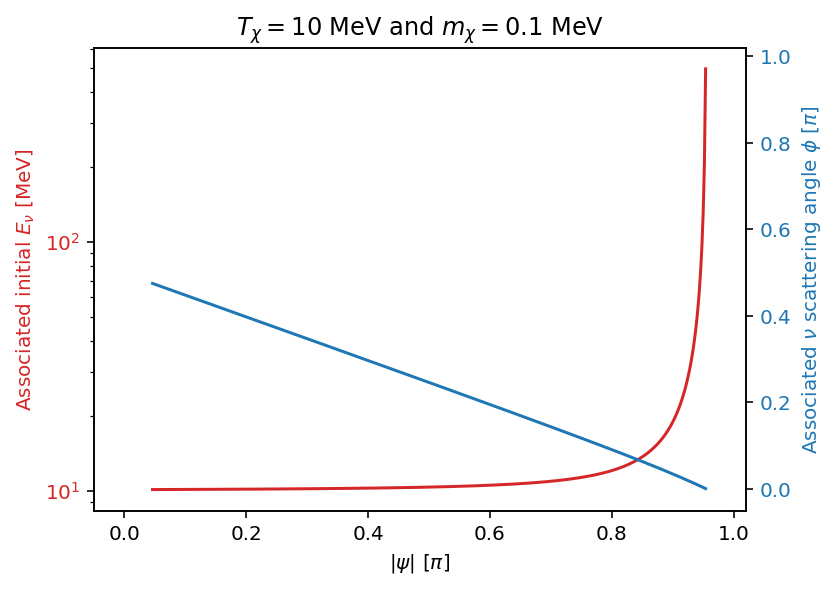

In [30]:
# separate the figure object and axes object
# from the plotting object
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel(r'$|\psi|~[\pi]$')
ax1.set_ylabel(r'Associated initial $E_\nu$ [MeV]', color=color)
ax1.plot(psi_work_ls, Ef_ls, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale('log')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'Associated $\nu$ scattering angle $\phi~[\pi]$', color=color)  # we already handled the x-label with ax1
ax2.plot(psi_work_ls, phi_ls, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-0.05,1.02)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(r'$T_\chi=$' + str(Tx) + ' MeV and $m_\chi=$' + str(mx) + ' MeV')
plt.xlim(-0.05,1.02)
plt.show()

### The total cross section
#### The directional $\sigma_{\chi\nu}$ in lab frame

The $\chi\nu$ cross section in lab frame that points $\psi_0$ direction corresponds to a unique $\phi_0$ that is determined by
$$
\phi_0=\tan^{-1}\left(\frac{\sin\psi_0}{E_\nu/p_\chi-\cos\psi_0}\right).
$$
This leads to
$$
\sigma_{\chi \nu}(\psi_0) =\int_{-1}^1 d\cos\phi\frac{d\sigma_{\chi\nu}}{d\cos\phi}\delta(\cos\phi-\cos\phi_0)=\frac{d\sigma_{\chi\nu}}{d\cos\phi}(\phi_0).
$$
####  The frame-independent $\sigma_{\chi e}$

Since the $\chi e$ scattering happened in the detector, we do not care the directional information and simply integrate over all possible angles.
Similar to the $\chi \nu$ scattering, but this time replace $f$ by $\chi$ since DM is relativistic and $\chi$ by $e$ as the electron is assuming at rest.
Thus we apply the frame-independent case,
$$
\sigma_{\chi e} = \int_{t_-}^{t_+} dt\frac{d\sigma_{\chi e}}{dt}
$$
where
$$
t_\pm = \frac{(m_\chi^2+m_e^2)}{2} -\frac{s}{2}-\frac{(m_e^2-m_\chi^2)^2}{2s}\pm\frac{\lambda(s,m_e^2,m_\chi^2)}{2s}.
$$
The 4-momenta in $\chi e$ scattering are $p_1=(E_\chi,0,0,p_\chi)$ and $p_2=(m_e,0,0,0)$. Thus the Mandelstam variables
\begin{align}
s &= (p_1+p_2)^2 = m_\chi^2+m_e^2 + 2E_\chi m_e
\end{align}
and $t$ is integrated over while
$$
u = 2(m_\chi^2+m_e^2) - s-t.
$$
Note that we can express that $E_\chi = T_\chi + m_\chi$.

In [7]:
def diff_sig_xnu(Tx,mx,mV,B,C,psi,gV,gD,max_Ef=100):
    """
    Differential cross section for SNnu-DM scattering at scattering angle psi for DM
    
    Input
    ------
    Ev: The initial SN neutrino energy, MeV
    Tx: The DM kinetic energy after boost, MeV
    mx: DM mass, MeV
    mV: mediator mass, MeV
    B: [bV,bA], coefficients for vector and axial-vector interactions at vertex
        Gamma. B = [1,0] indicates vector interaction only
    C: [cV,cA], coefficients for vector and axial-vector interactions at vertex
        Gamma_prime. C = [1,0] indicates vector interaction only
    psi: The DM scattering angle after boost, rad
    gV: the DM-nu coupling constant
    gD: the DM-DM coupling constant
    
    Output
    ------
    scalar: cm^2
    """
    # Get the associated initial nu energy and its scattering angle phi
    Ev,phi,flag,_ = get_Ef_phi(Tx,mx,psi,max_Ef)
    
    # Calculating the DM-nu cross section at angle psi and converts it into cm^2
    if flag == 'valid':
        crox = (gV*gD)**2*diff_sig_lab(Ev,mx,mV,B,C,phi)*to_cm2
    elif flag == 'invalid': # if it is invalid, the inputs cannot happen
        crox = 0
    return crox


def sig_xe(Tx,mx,mV,B,C,eps,gD):
    """
    The total cross section for DM-electron scattering in the detector
    
    Input
    ------
    Tx: The DM kinetic energy after boost, MeV
    mx: DM mass, MeV
    mV: mediator mass, MeV
    B: [bV,bA], coefficients for vector and axial-vector interactions at vertex
        Gamma. B = [1,0] indicates vector interaction only
    C: [cV,cA], coefficients for vector and axial-vector interactions at vertex
        Gamma_prime. C = [1,0] indicates vector interaction only
    
    Output
    ------
    scalar: cm^2
    """
    Ex = Tx+mx    # The DM total energy
    s = mx**2+me**2+2*Ex*me    # The s channel
    tp,tm = get_tpm(mx,me,s)    # The allowed range for t channel
    e2 = 4*np.pi/137    # e^2 in terms of fine structure constant
    
    # evaluate cross section
    dsdt = lambda t: diff_sig_fi(s,t,mx,me,mV,B,C)*to_cm2*(eps*gD)**2*e2
    crox,_ = quad(dsdt,tm,tp)
    
    return crox
        
        
def sig_xx(mx,mV,gD):
    """
    The total cross section for DM self-scattering (non-relativistic)
    
    Input
    ------
    mx: DM mass, MeV
    mV: mediator mass, MeV
    gD: the DM self-coupling
    
    Output
    ------
    scalar: cm^2
    """    
    crox = gD**4*mx**2/mV**4/16/np.pi**2
    return crox*to_cm2


def gD_SIDM(constraint,mx,mV):
    """
    Get the associated gD from SIDM constraint, assuming DM is non-relativistic
    """
    fac = 16*np.pi**2*mV**4/mx/g2MeV/to_cm2
    gD = (constraint*fac)**(1/4)
    return gD

### The DM-SM interaction Lagrangian

Following D. Croon *et al.*, JHEP **01**, 107 (2017), the portal between DM and SM is described by the $L_\mu-L_\tau$ model with extra $U(1)_D$ gauge boson $V$,
$$
\mathcal{L}_{V}\supset -\frac{1}{4}V_{\mu\nu} V^{\mu\nu} - \frac{\varepsilon}{2}V_{\mu\nu}Z^{\mu\nu}+\frac{1}{2}m_V^2 V_\mu V^\mu + g_V V_\mu(\bar{\ell}_\mu \gamma^\mu \ell_\mu
-\bar{\ell}_\tau \gamma^\mu \ell_\tau +\bar{\mu}_R \gamma^\mu \mu_R-\bar{\tau}_R\gamma^\mu\tau_R)
$$ 
where $\ell_{\mu}=(\mu_L,\nu_{\mu L})$, $\ell_{\tau}=(\tau_L,\nu_{\tau L})$, $V^{\mu\nu}=\partial^\mu V^\nu-\partial^\nu V^\mu$, $Z$ the SM $Z$-boson and $g_V$ the coupling strength between $V$ and SM $\ell$ field.
Suppose DM field $\chi$ is fermionic and charged under $U(1)_D$ as well, the Lagrangian
$$
\mathcal{L}_\chi = g_D V_\mu \bar{\chi} \gamma^\mu \chi 
$$
that describes the dark sector interaction is also allowed.

Therefore, the diagrams for DM-$\nu$ and DM-$e$ scatterings are shown below:
<div>
<center><img src="../plots/vector_xv.png" alt='DM-nu scattering' class='center' width="250"/>        
<img src="../plots/vector_xe.png" alt='DM-e scattering' class='center' width="250"/></center>
</div>

#### The DM-$\nu$ scattering

The DM-$\nu$ interaction happens at tree level as given by the Lagrangian. So we take $\{b_V,b_A\}=\{c_V,c_A\}=\{1,0\}$, thus $B_\pm=C_\pm =1$.

#### The DM-$e$ scattering 

##### When $\varepsilon \neq 0$
The DM-$e$ scattering is in principle through the kinetic mixing. If $\varepsilon \neq 0$, we simply take $B_\pm=C_\pm=1$ as the neutrino case.
But replace $g_V$ with $\varepsilon e$ where $e$ is the electric charge.

##### When $\varepsilon = 0$

Another situation is the missing $\varepsilon$. Though $\varepsilon$ is allowed due to gauge invariant of the $U(1)$ field, however, it is artificial.
When $\varepsilon$ is absent, DM-$e$ interaction ceases to exist and $\sigma_{\chi e}=0$.
But this is not exactly correct. Even there is no direct mixing between $V$ and SM photon, the two can still be connected together via $\mu$ or $\tau$ loops.
As $V_\mu \bar{\ell}\gamma^\mu \ell$  and $A_\mu \bar{\ell}\gamma^\mu \ell$ are possible where $\ell=\mu,\tau$ and $A_\mu$ the SM photon field.
The Feynman diagram is depicted below
<div>
<center><img src="../plots/mutau_loop.png" alt='Mu-Tau loop' class='center' width="300"/>        
</center>
</div>
This loop diagram serves as the new kinetic mixing even the external $\varepsilon^\prime$ is 0.
Thus,
$$
\varepsilon^\prime = -\frac{eg_V}{2\pi^2}\int_0^1 dx\,x(1-x)\ln\left[\frac{m_\tau^2-x(1-x)q^2}{m_\mu^2-x(1-x)q^2}\right]
$$
where $q$ is the momentum transfer. If $m_\mu \gg q$, the above integral has the approximation
$$
\varepsilon^\prime \to -\frac{eg_V}{6\pi^2}\ln\frac{m_\tau}{m_\mu}\simeq -0.014434g_V.
$$

Hence, we summarize that for the kinetic mixing, there are two cases. The first is that $\varepsilon$ is independent of $g_V$ and dominates the DM-$e$ interaction. The second is that no external $\varepsilon$ and the kinetic mixing is purely induced by $\mu$ and $\tau$ loops.

In [8]:
# DM-nu scattering for vector interaction
# No B and C are needed for input
def sig_xnu_vector(Tx,mx,mV,psi,gV,gD,max_Ef=1000):
    return diff_sig_xnu(Tx,mx,mV,[1,0],[1,0],psi,gV,gD,max_Ef)


# DM-e scattering for vector interaction
def sig_xe_vector(Tx,mx,mV,eps,gD):
    return sig_xe(Tx,mx,mV,[1,0],[1,0],eps,gD)
    

# Kinetic mixing from mu/tau loops
def eps_prime(gV,q):
    """
    Get the epsilon induced by mu/tau loops
    
    Input
    ------
    gV: the DM-lepton coupling constant
    q: the momentum transfer, in MeV
    
    Output
    ------
    scalar: the epsilon
    """
    # electric charge
    e = np.sqrt(4*np.pi/137)
    
    # Define q^2. In this t-channel, q^2 is always spacelike
    q2 = -q**2
    # define the integrand
    integ = lambda x: x*(1-x)*np.log((mtau**2-x*(1-x)*q2)/(mmu**2-x*(1-x)*q2))*e*gV/2/np.pi**2
    # evaluate epsilon
    eps_p,_ = quad(integ,0,1)
    return -eps_p
    #if show_error == False:
    #    return -eps_p
    #elif show_error == True:
    #    return -eps_p,error
    #else:
    #    raise ValueError('Option \'show_error\' must be either True or False, please check again!')

In [81]:
Tx = 10
psi = 0.01
mx_list = np.logspace(-6,1,30)
sig_ls = []
for mx in mx_list:
    sig_ls.append(sig_xnu_vector(Tx,mx,mx/3,psi,1,1))

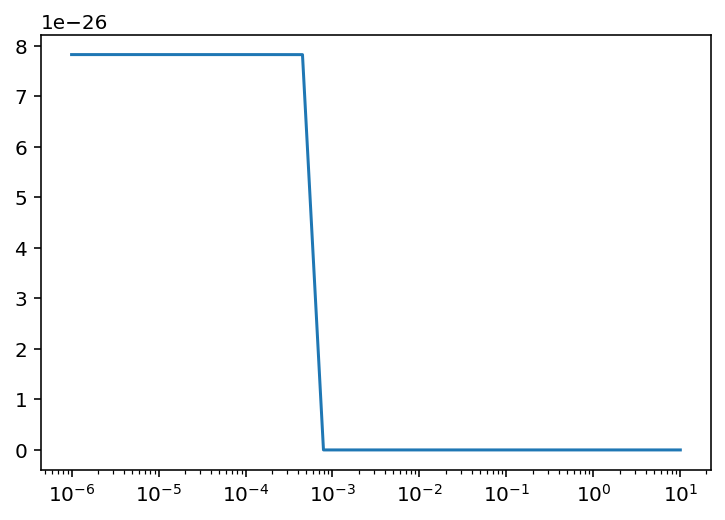

In [82]:
plt.plot(mx_list,sig_ls)
plt.xscale('log')
#plt.yscale('log')

In [17]:
gV = 1
q_list = np.logspace(-1,4,50)
epsp_list = []
for q in q_list:
    epsp_list.append(eps_prime(gV,q))

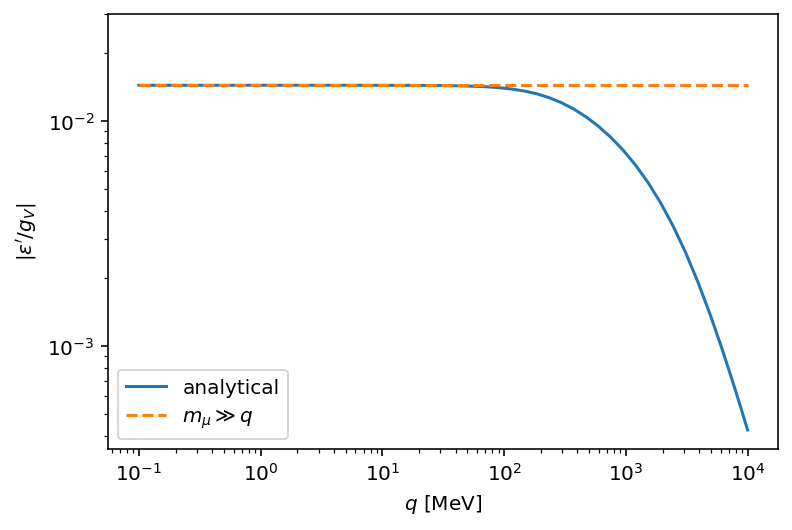

In [165]:
plt.plot(q_list,np.abs(epsp_list),label='analytical')
plt.plot([q_list[0],q_list[-1]],[0.014434*gV,0.014434*gV],'--',label=r'$m_\mu \gg q$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.00035,0.03)
plt.legend()
plt.xlabel('$q$ [MeV]')
plt.ylabel(r'$|\varepsilon^\prime/g_V|$')
#plt.title('$g_V=0.01$')
plt.savefig('../plots/eps_prime.pdf',bbox_inches='tight')
plt.show()

### Scaling the constraint from earlier work

#### DM-$\nu$ cross section
At this scaling stage, we have no angular information for DM-$\nu$ scattering to input, so I'll use the energy/angle-averaged DM-$\nu$ cross section $\bar{\sigma}_{\chi\nu}$,
$$
\bar{\sigma}_{\chi\nu}=\frac{1}{2\Delta E_\nu}\int_{-1}^{1}  d\cos\phi\int_{E_{\nu,{\rm min}}}^{E_{\nu,{\rm max}}} dE_\nu\, \sigma_{\chi\nu}(E_\nu,\phi).
$$
where $\{E_{\nu,{\rm min}},E_{\nu,{\rm max}}\}=\{0.5\,{\rm MeV},100\,{\rm MeV}\}$ and $\Delta E_\nu = E_{\nu,{\rm max}}-E_{\nu,{\rm max}}$. The azimuthal angle is assumed to be symmetric.
We define $\tilde{\bar{\sigma}}_{\chi\nu}\equiv \bar{\sigma}_{\chi\nu}/g_V^2 g_D^2$, thus $\bar{\sigma}_{\chi \nu}$ can be scaled according to given $g_V$ and $g_D$.


#### DM-$e$ cross section

Similar to $\bar{\sigma}_{\chi\nu}$, we also take energy-average for $\sigma_{\chi e}$. However, unlike the $\sigma_{\chi\nu}$, theree's no need for angle-average since we integrated over all angle in the detector.
Thus,
$$
\bar{\sigma}_{\chi e}=\frac{1}{\Delta T_\chi} \int_{T_{\chi,{\rm min}}}^{T_{\chi,{\rm max}}}dT_\chi\, \sigma_{\chi e}(T_\chi).
$$
Similarily, we also define $\tilde{\bar{\sigma}}_{\chi e}=\bar{\sigma}_{\chi e}/g_D^2\varepsilon^2$.

In [9]:
def sig_xnu_bar(Ev_range,mx,mV,gV,gD):
    # Energy range of interest
    Ev_min,Ev_max = Ev_range
    
    # Frame-independent cross section
    def _sig_xnu(Ev):
        s = 2*Ev*mx + mx**2
        tp,tm = get_tpm(0,mx,s)
        crox,_ = quad(lambda t: diff_sig_fi(s,t,0,mx,mV,[1,0],[1,0])*to_cm2,tm,tp)
        return crox
    
    # Evaluate energy-average cross section
    avg_crox,_ = quad(_sig_xnu,Ev_min,Ev_max)
    # Including coupling constants
    avg_crox = avg_crox*(gV*gD)**2/(4*np.pi)/(Ev_max-Ev_min)
    return avg_crox


def sig_xe_bar(Tx_range,mx,mV,eps,gD):
    
    # Get the Txmin and Txmax
    Tx_min,Tx_max = Tx_range
    
    #sig_xe(Tx,mx,mV,B,C,eps,gD)
    _sig_xe = lambda Tx: sig_xe(Tx,mx,mV,[1,0],[1,0],eps,gD)#sig_xe_vector(Tx,mx,mV,eps,gD)
    
    avg_crox,_ = quad(_sig_xe,Tx_min,Tx_max)
    avg_crox = avg_crox/(Tx_max-Tx_min)
    return avg_crox


def sig_xe_bar_nokin(Tx_range,mx,mV,gV,gD):
    """
    No kinetic mixing
    """
    # Get the Txmin and Txmax
    Tx_min,Tx_max = Tx_range
    
    _sig_xe = lambda Tx: sig_xe_vector(Tx,mx,mV,eps_prime(gV,Tx),gD)
    
    avg_crox,_ = quad(_sig_xe,Tx_min,Tx_max)
    avg_crox = avg_crox/(Tx_max-Tx_min)
    return avg_crox

In [109]:
mx_list = np.logspace(-6,1,50)
Tmax_list = np.logspace(-2,4,20)
sig_xnu_list = []
sig_xe_list = []
for mx in mx_list:
    sig_xnu_list.append(sig_xnu_bar([0.5,100],mx,mx/3,1,1))
    sig_xe_list.append(sig_xe_bar([0.5,100],mx,mx/3,1,1))
sig_xnu_list = np.array(sig_xnu_list)
sig_xe_list = np.array(sig_xe_list)

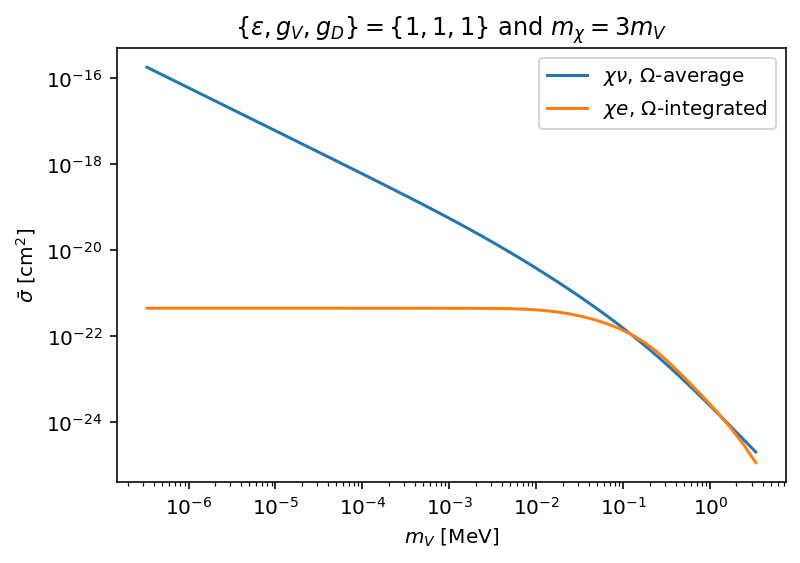

In [12]:
plt.plot(mx_list/3,sig_xnu_list,label=r'$\chi\nu$, $\Omega$-average')
plt.plot(mx_list/3,sig_xe_list,label='$\chi e$, $\Omega$-integrated')
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-27,1e-15)
plt.xlabel(r'$m_V$ [MeV]')
plt.ylabel(r'$\bar{\sigma}~[{\rm cm}^2]$')
plt.title(r'$\{\varepsilon,g_V,g_D\}=\{1,1,1\}~{\rm and}~m_\chi=3m_V$')
plt.legend()
#plt.savefig('../plots/cross_section_lighter_mV.pdf',bbox_inches='tight')
plt.show()

In [13]:
#Tmax_list = np.logspace(-2,4,20)
gV,gD = 1,1
sig_xe_nokin_heavier_list = []
sig_xe_nokin_lighter_list = []
sig_xe_nokin_equal_list = []
for mx in mx_list:
    sig_xe_nokin_heavier_list.append(sig_xe_bar_nokin([0.5,100],mx,3*mx,gV,gD))
    sig_xe_nokin_equal_list.append(sig_xe_bar_nokin([0.5,100],mx,mx,gV,gD))
    sig_xe_nokin_lighter_list.append(sig_xe_bar_nokin([0.5,100],mx,mx/3,gV,gD))

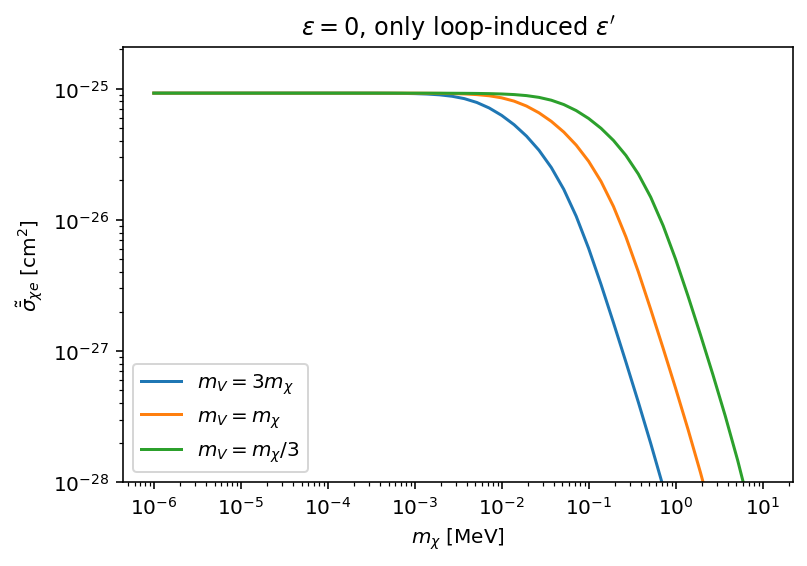

In [14]:
plt.plot(mx_list,sig_xe_nokin_heavier_list,label=r'$m_V = 3m_\chi$')
plt.plot(mx_list,sig_xe_nokin_equal_list,label='$m_V = m_\chi$')
plt.plot(mx_list,sig_xe_nokin_lighter_list,label='$m_V = m_\chi/3$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-28,)
plt.xlabel(r'$m_\chi$ [MeV]')
plt.ylabel(r'$\tilde{\bar{\sigma}}_{\chi e}~[{\rm cm}^2]$')
plt.title(r'$\varepsilon= 0$, only loop-induced $\varepsilon^\prime$')
plt.legend()
#plt.savefig('../plots/sigxe_no_kinetic_mix.pdf',bbox_inches='tight')
plt.show()

Thermal relic constraint for $m_V<m_\chi$ gives that
$$
\kappa=\langle \sigma v\rangle = \frac{g_D^4}{16\pi m_\chi^2}\sqrt{1-\left(\frac{m_V}{m_\chi}\right)^2}
$$
where $\kappa = 6\times 10^{-26}\,{\rm cm^3 s^{-1}}$ for fermionic DM. Hence for a given $g_D$, the mediator mass $m_V$ is also constrained by
$$
m_V=m_\chi\sqrt{1-\left( \frac{16\kappa\pi}{g_D^4}m_\chi^2\right)^2}.
$$
In order for the above perturbative result to be valid, there's a minimum $g_D$ value,
$$
g_D^{\rm min} = (16\kappa\pi m_\chi^2)^{1/4}.
$$
If $g_D$ is smaller than $g_D^{\rm min}$, the second term in the square root will become larger than 1 hence $m_V$ turns into imaginary.

On the other hand, the DM-DM self-interaction cross section in the NR limit is given by
$$
\sigma_{\chi\chi} = \frac{g_D^4}{16\pi^2}\frac{m_\chi^2}{m_V^4}
$$
and SIDM in general gives the upper limit $\eta$ for the ratio $\sigma_{\chi\chi}/m_\chi$. Thus we have
$$
m_V >\frac{g_D}{2\sqrt{\pi}}\left(\frac{m_\chi}{\eta}\right)^{1/4}
$$

In [63]:
def thermal_relic_mV(mx,gD,sigv=6e-26):
    sigv = sigv*6.529e-22/(1.973e-11)**3
    mV = mx*np.sqrt(1-(16*sigv*np.pi*mx**2/gD**4)**2)
    return mV


def gD_min(mx,sigv=6e-26):
    sigv = sigv*6.529e-22/(1.973e-11)**3
    gdmin= (16*sigv*np.pi*mx**2)**0.25
    return gdmin


def SIDM_mV(mx,gD,eta=10):
    mx = np.asarray(mx)
    gD = np.asarray(gD)
    eta = eta/g2MeV/to_cm2
    mV = 0.5*gD/np.sqrt(np.pi)*(mx/eta)**0.25
    return mV

In [98]:
gDls_1 = np.logspace(np.log10(gD_min(1)),-3,100)

(0.03, 2.2242492765248114)

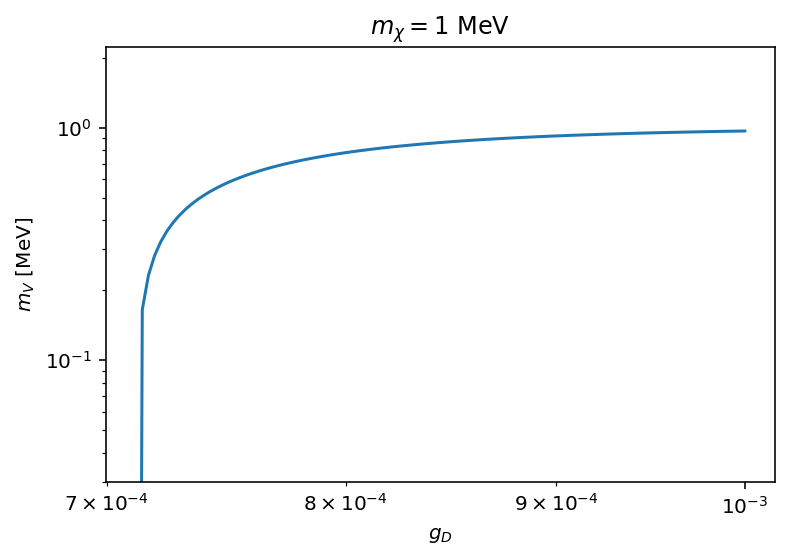

In [105]:
plt.plot(gDls_1,thermal_relic_mV(1,gDls_1),label=r'$g_D=10^{-2}$')
#plt.plot(mxls,thermal_relic_mV(mxls,1),label=r'$g_D=1$')
#plt.plot(mxls,thermal_relic_mV(mxls,1e-3),'-.',label=r'$g_D=10^{-2}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$g_D$')
plt.ylabel('$m_V$ [MeV]')
plt.title(r'$m_\chi=1$ MeV')
plt.ylim(3e-2,)

In [ ]:
mxls=np.logspace(-6,2,100)

/var/folders/dr/w2wmjyk173551q0j44jf3fnr0000gn/T/ipykernel_95677/3710749743.py:3: RuntimeWarning: invalid value encountered in sqrt
  mV = mx*np.sqrt(1-(16*sigv*np.pi*mx**2/gD**4)**2)


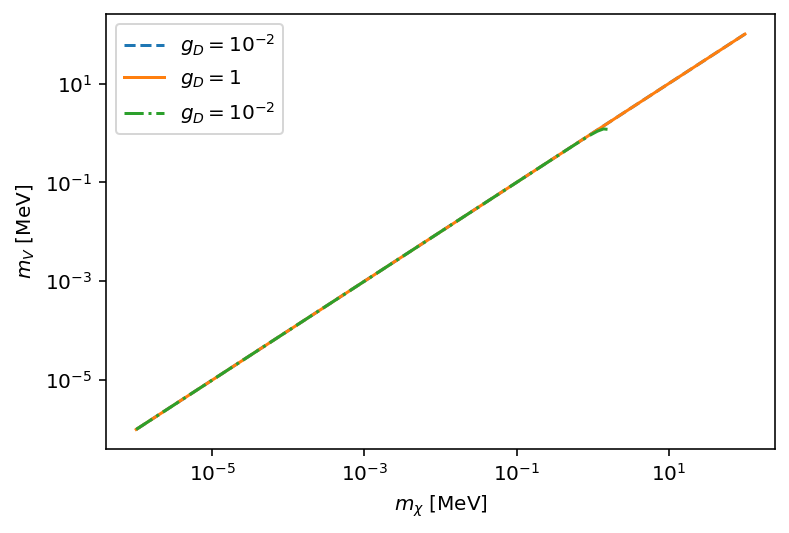

In [55]:
plt.plot(mxls,thermal_relic_mV(mxls,100),'--',label=r'$g_D=10^{-2}$')
plt.plot(mxls,thermal_relic_mV(mxls,1),label=r'$g_D=1$')
plt.plot(mxls,thermal_relic_mV(mxls,1e-3),'-.',label=r'$g_D=10^{-2}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_\chi$ [MeV]')
plt.ylabel('$m_V$ [MeV]')
plt.legend()

In [30]:
# Load constraints
LMC = np.loadtxt('../constraints/LMC.txt')  # ours LMC
MW_SK = np.loadtxt('../constraints/MW_SK.txt')  # ours MW in SK
MW_HK = np.loadtxt('../constraints/MW_HK.txt')  # ours MW in HK
SN_equal = 10**np.loadtxt('../constraints/McDermott/SN1987_eps1.txt',delimiter=',') # SN equal eps and gz
CCFR_equal = 10**np.loadtxt('../constraints/McDermott/CCFR_eps1.txt',delimiter=',') # CCFR equal eps and gz
Borexino_equal = 10**np.loadtxt('../constraints/McDermott/Borexino_eps1.txt',delimiter=',') # Borexino equal eps and gz
StarCool_equal = 10**np.loadtxt('../constraints/McDermott/StellarCooling_eps1.txt',delimiter=',') # Stellar cooling equal eps and gz
gm2_equal = 10**np.loadtxt('../constraints/McDermott/g-2_eps1.txt',delimiter=',') # g-2 equal eps and gz
# no kinetic mixing
SN_nokin = 10**np.loadtxt('../constraints/McDermott/SN1987_eps0.txt',delimiter=',') # SN no eps
CCFR_nokin = 10**np.loadtxt('../constraints/McDermott/CCFR_eps0.txt',delimiter=',') # CCFR no eps
gm2_nokin = 10**np.loadtxt('../constraints/McDermott/g-2_eps0.txt',delimiter=',') # g-2 no eps

In [11]:
def get_constraint(mx,source='LMC'):
    """
    Get the constraint from our last paper
    """
    if source == 'LMC':
        s = np.interp(mx,LMC.T[0],LMC.T[1])
    elif source == 'MW_SK':
        s = np.interp(mx,MW_SK.T[0],MW_SK.T[1])
    elif source == 'MW_HK':
        s = np.interp(mx,MW_HK.T[0],MW_HK.T[1])
    return s

In [64]:
E_range = [0.5,100]
source = 'MW_SK'
gV_scaled_gDm2 = []
gV_scaled_gD1 = []
gV_scaled_SIDM = []
mx_list = np.logspace(-6,1,50)
#gV_scaled_lower = []
#gV_scaled_upper = []
for mx in mx_list:
    mV = mx
    sig_norm = sig_xnu_bar(E_range,mx,mV,1,1)*sig_xe_bar(E_range,mx,mV,1,1)
    sig_constraint = get_constraint(mx,source)
    gV_scaled_gD1.append(np.sqrt(sig_constraint/1**2/np.sqrt(sig_norm)))
    
for mx in mx_list:
    mV = SIDM_mV(mx,1,eta=10)
    sig_norm = sig_xnu_bar(E_range,mx,mV,1,1)*sig_xe_bar(E_range,mx,mV,1,1)
    sig_constraint = get_constraint(mx,source)
    gV_scaled_SIDM.append(np.sqrt(sig_constraint/1**2/np.sqrt(sig_norm)))

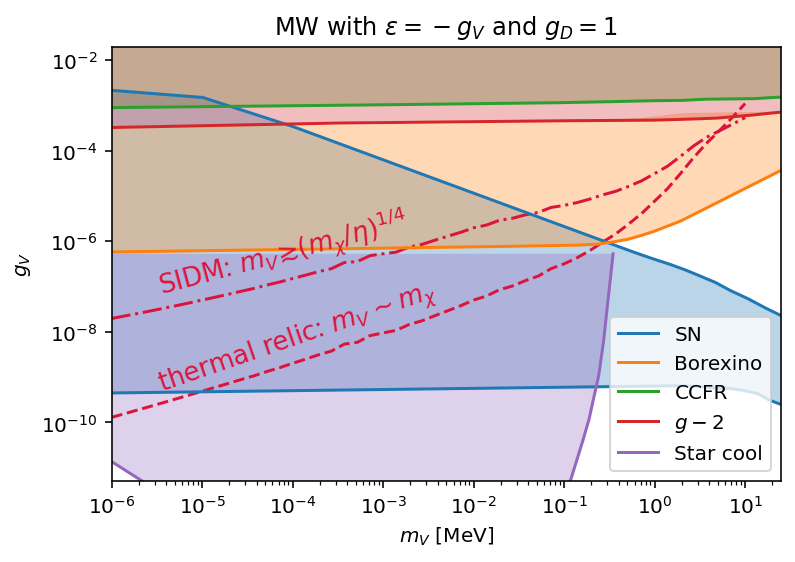

In [89]:
# our scaled constraints
#plt.plot(mx_list,gV_scaled_gDm2,'-.',color='crimson')
plt.plot(mx_list,gV_scaled_gD1,'--',color='crimson')
plt.text(3e-6, 5e-10, 'thermal relic: $m_V\sim m_\chi$', color='crimson',fontsize=13,rotation=19)
plt.plot(mx_list,gV_scaled_SIDM,'-.',color='crimson')
plt.text(3e-6, 7e-8, 'SIDM: $m_V\gtrsim (m_\chi/\eta)^{1/4}$', color='crimson',fontsize=13,rotation=15)
#plt.plot(mx_list/3,gV_scaled_upper,'r--')
#plt.fill_between(mx_list/3,gV_scaled_lower, gV_scaled_upper,alpha=0.3,color='r')
# SN
plt.plot(SN_equal.T[0],SN_equal.T[1],label='SN')
plt.fill_between(SN_equal.T[0],SN_equal.T[1],1e-10,alpha=0.3)
# Borexino
plt.plot(Borexino_equal.T[0],Borexino_equal.T[1],label='Borexino')
plt.fill_between(Borexino_equal.T[0],Borexino_equal.T[1],gm2_equal.T[1][:11],alpha=0.3)
# CCFR
plt.plot(CCFR_equal.T[0],CCFR_equal.T[1],label='CCFR')
plt.fill_between(CCFR_equal.T[0],CCFR_equal.T[1], 1,alpha=0.3)
# g-2
plt.plot(gm2_equal.T[0],gm2_equal.T[1],label='$g-2$')
plt.fill_between(gm2_equal.T[0],gm2_equal.T[1],1,alpha=0.3)
# Stellar
plt.plot(StarCool_equal.T[0],StarCool_equal.T[1],label='Star cool')
plt.fill_between(StarCool_equal.T[0],StarCool_equal.T[1], StarCool_equal.T[1][-1],alpha=0.3)
plt.xlim(1e-6,25)
plt.ylim(5e-12,2e-2)
plt.legend(loc='lower right')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_V$ [MeV]')
plt.ylabel(r'$g_V$')
plt.title(r'MW with $\varepsilon=-g_V$ and $g_D=1$')
plt.savefig('../plots/MW_scaled_sensitivity_with_kinetic.pdf', bbox_inches='tight')
plt.show()

In [127]:
source = 'MW_SK'
gV_nokin_scaled = []
#gV_nokin_scaled_upper = []
for mx in mx_list:
    mV = mx
    sig_norm = sig_xnu_bar(E_range,mx,mV,1,1)*sig_xe_bar_nokin(E_range,mx,mV,1,1)
    sig_constraint = get_constraint(mx,source)
    gV_nokin_scaled.append(np.sqrt(sig_constraint/1**2/np.sqrt(sig_norm)))
    
    #gD_low = gD_SIDM(0.1,mx,mV)
    #gD_high = gD_SIDM(10,mx,mV)
    #gV_high = np.sqrt(sig_constraint/gD_low**2/np.sqrt(sig_norm))
    #gV_low = np.sqrt(sig_constraint/gD_high**2/np.sqrt(sig_norm))
    #gV_nokin_scaled_lower.append(gV_low)
    #gV_nokin_scaled_upper.append(gV_high)

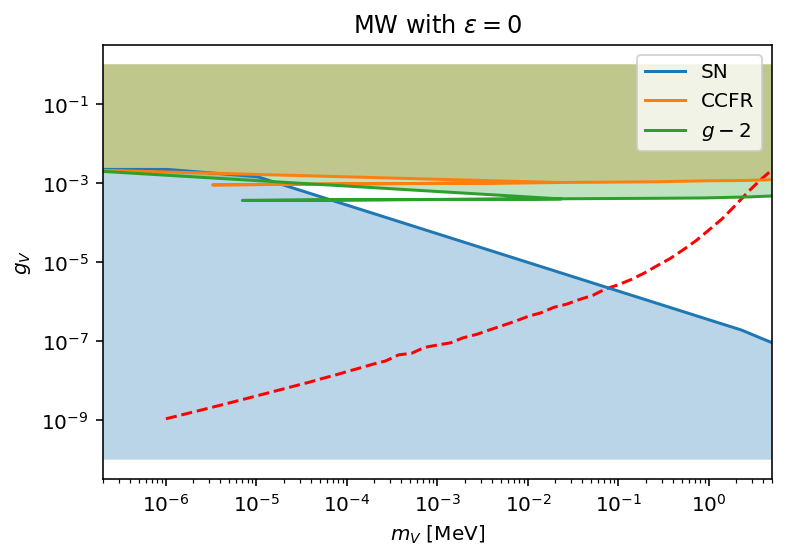

In [128]:
# no kinetic mixing
plt.plot(mx_list,gV_nokin_scaled,'r--')
#plt.plot(mx_list/3,gV_nokin_scaled_upper,'r--')
#plt.fill_between(mx_list/3,gV_nokin_scaled_lower, gV_nokin_scaled_upper,alpha=0.3,color='r')
# SN
plt.plot(SN_nokin.T[0],SN_nokin.T[1],label='SN')
plt.fill_between(SN_nokin.T[0],SN_nokin.T[1], 1e-10,alpha=0.3)
# CCFR
plt.plot(CCFR_nokin.T[0],CCFR_nokin.T[1],label='CCFR')
plt.fill_between(CCFR_nokin.T[0],CCFR_nokin.T[1], 1,alpha=0.3)
# g-2
plt.plot(gm2_nokin.T[0],gm2_nokin.T[1],label='$g-2$')
plt.fill_between(gm2_nokin.T[0],gm2_nokin.T[1], 1,alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_V$ [MeV]')
plt.ylabel(r'$g_V$')
plt.xlim(2e-7,5)
#plt.ylim(1e-7,3e-2)
plt.legend()
plt.title(r'MW with $\varepsilon=0$')
plt.savefig('../plots/MW_scaled_sensitivity_no_kinetic.pdf', bbox_inches='tight')
plt.show()

In [41]:
def ff(x):
    return x**2

In [42]:
ff(5)

25

In [43]:
pool = mp.Pool(processes=4)
pool.map(ff,np.array([1,2,3,4,5]))

Process SpawnPoolWorker-39:
Process SpawnPoolWorker-38:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/yenhsun/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/yenhsun/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/yenhsun/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/yenhsun/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'ff' on <module '__main__' (built-in)>
  File "/Users/yenhsun/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/yenhsun/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/yenhsun/opt/

KeyboardInterrupt: 